CHAPTER 05 트리알고리즘  
05-2 교차 검증과 그리드 서치

모델이 실제 환경에서 잘 작동하는지 확인하려면, 테스트 데이터는 모델이 본 적 없는 데이터여야 함  
하지만 모델 튜닝 중 테스트 세트를 여러번 보면 모델이 테스트 세트에 과적합 될 수 있음
> 해결 위해 훈련 세트를 나눠 검증 세트를 둠

훈련 세트에서 모델을 훈련하고 검증 세트로 모델을 평가(매개변수를 바꿔가며 가장 좋은 모델 고름)   
--> 선택한 매개변수를 사용해 훈련 세트와 검증 세트를 합쳐 전체 훈련 데이터에서 모델을 다시 훈련  
--> 테스트 세트에서 최종 점수를 평가 

In [34]:
# 데이터 불러오기
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [35]:
# class 열을 타깃으로, 나머지 열은 특성으로 사용
data = wine[['alcohol','sugar','pH']]
target = wine['class']

In [36]:
# 훈련 세트와 데이터 세트 나눔
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [37]:
# train_input과 train_target을 다시 train_test_split() 함수에 넣어 훈련 세트와 검증 세트 만듦
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [38]:
print(sub_input.shape, val_input.shape) # 훈련 세트와 검증 세트의 크기 확인

(4157, 3) (1040, 3)


In [39]:
# 모델 만들고 평가
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


과대적합 보임

[교차 검증]  
: 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복

> 3-폴드 교차 검증
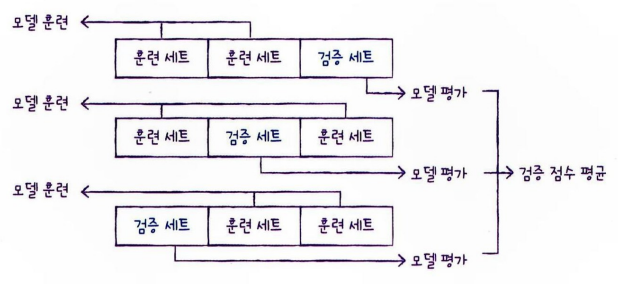

In [40]:
# sklearn의 교차검증 함수 'cross_validate()'사용
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.0119009 , 0.0080905 , 0.0073967 , 0.00747538, 0.00776505]), 'score_time': array([0.00221205, 0.00198841, 0.00166678, 0.00169945, 0.00174284]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


fit_time: 모델을 훈련하는 시간  
score_time: 모델을 검증하는 시간  
test_score: 평균값이 검증 폴드의 점수


In [41]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


[훈련 데이터를 섞으려면?]  
- train_test_split(): 전체 데이터를 섞은 후 훈련세트와 테스트 세트로 나눔
- cross_validate() 함수의 분할기 지정  
  > 회귀 모델: KFold  
  > 분류 모델: StratifiedKFold

In [42]:
from sklearn.model_selection import StratifiedKFold
score = cross_validate(dt, train_input, train_target, cv=StratifiedKFold()) # 훈련 세트 섞어 교차 검증
print(np.mean(scores['test_score']))

0.855300214703487


In [43]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 교차검증 10회
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(score['test_score']))

0.855300214703487


결정 트리의 매개변수 값을 바꿔가며 가장 성능이 좋은 모델 찾기  
> 테스트 세트를 사용하지 않고 교차 검증을 이용  

[하이퍼파라미터 튜닝]  
: 결정 트리 모델에서 max_depth의 최적값은 min_samples_split 매개변수의 값이 바뀌면 함께 달라짐  
  > 두 매개변수를 동시에 바꿔가며 최적의 값을 찾아야 함   

[GridSerchCV 클래스]  
-  하이퍼파라미터 탐색과 교차 검증을 한 번에 수행  
- 별도로 cross_validate() 함수를 호출할 필요 없음  


In [44]:
# 기본 매개변수를 사용한 결정 트리 모델에서 min_impurity_decrease 매개변수의 최적값 찾기  
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease':[0.0001,0.0002,0.0003,0.0004,0.0005]} # 탐색할 매개변수, 탐색할 값 리스트를 딕셔너리로 만듦

In [45]:
# GridSearchCV 함수에 탐색대상 모델, parasm 변수 전달해 그리드 서치 객체 만듦
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs= -1)

= 그리드 서치 객체는 min_impurity_decrease 값을 바꿔가며 결정 트리 모델을 사용해 교차 검증을 총 5번 실행  
- cv 매개변수 기본값은 5로 min_impurity_decrease 값마다 5-폴드 교차 검증을 수행함(5*5=총 25번)  
- n_jobs 매개변수의 기본값은 1로, -1로 지정하면 시스템에 있는 모든 코어를 사용함 

In [46]:
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'min_impurity_decrease': [0.0001, 0.0002, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [47]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


그리드 서치는 훈련이 끝나면 교차 검증 점수가 가장 높은 모델의 매개변수 조합으로   
전체 훈련 세트에서 자동으로 다시 모델을 훈련  
- gs.best_estimator_ 속성에 저장되어 있음 : 이 모델을 일반 결정 트리처럼 똑같이 사용 가능  

In [48]:
print(gs.best_params_) # 그리드 서치로 찾은 최적의 매개변수 확인

{'min_impurity_decrease': 0.0001}


In [49]:
print(gs.cv_results_['mean_test_score']) # 각 매개변수에서 수행한 교차 검증의 평균 점수 확인

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [50]:
# 교차 검증 평균 점수의 결과와 그리드 서치로 찾은 최적의 매개변수와 일치하는 것 확인
print(gs.cv_results_['params'][gs.best_index_]) 

{'min_impurity_decrease': 0.0001}


[과정 정리]  
1. 탐색할 매개변수 지정  
2. 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합 찾기  
   : 이 조합은 그리드 서치 객체에 저장  
3. 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종 모델을 훈련  
   : 이 모델도 그리드 서치 객체에 저장  

In [51]:
# 조금 더 복잡한 매개변수 조합 탐색해보기
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),    # 0.0001부터 0.0009까지 0.0001씩 증가
          'max_depth': range(5, 20, 1),     # 정수만 사용(5부터 19까지 1씩 증가)
          'min_samples_split': range(2, 100, 10)}  # 2부터 99까지 10씩 증가

9 * 15 * 10 = 1,350  
기본값 5-폴드 교차 수행되므로  
1,350 * 5 = 6,750개의 모델 생성  

In [52]:
# 그리드 서치 실행
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(5, 20), 'min_impurity_decrease': array([0.0001... 0.0009]), 'min_samples_split': range(2, 100, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [53]:
print(gs.best_params_) # 최상의 매개변수 조합 확인

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [54]:
print(np.max(gs.cv_results_['mean_test_score'])) # 최상의 교차 검증 점수 확인

0.8683865773302731


[랜덤서치]  
: 매개변수의 값 목록을 전달하는 것이 아닌 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달  

[scipy(사이파이)]  
: 파이썬의 핵심 과학 라이브러리(적분, 보간, 선형 대수, 확률 등을 포함한 수치 계산 전용)

보간: 두 점 사이의 값을 수학적으로 계산해 채우는 것

In [55]:
from scipy.stats import uniform, randint

uniform, randint: 주어진 범위에서 고르게 값을 뽑음(균등 분포에서 샘플링 한다)  
randint: 정숫값  /  uniform: 실숫값  (임의로 샘플링)

In [56]:
# 0에서 10 사이의 범위를 갖는 randint 객체 만들고 10개의 숫자를 샘플링
rgen = randint(0,10)
rgen.rvs(10)

array([1, 4, 0, 0, 7, 0, 3, 7, 1, 2])

In [57]:
# 1000개 샘플링 후 각 숫자의 개수 세어보기
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([100, 109, 102,  86,  89, 106, 102, 108,  88, 110]))

In [59]:
# uniform 클래스
ugen = uniform(0,1)
ugen.rvs(10)

array([0.05199232, 0.22370091, 0.1316576 , 0.25195036, 0.32722453,
       0.66530542, 0.85937187, 0.43891754, 0.16464237, 0.74251775])

랜덤 서치에 randint, uniform 클래스 객체를 넘겨주고  
샘플링 횟수 정한 후 최적의 매개변수 찾게 하기  

In [64]:
# 탐색할 매개변수의 딕셔너리 만들기(min_samples_leaf 매개변수 추가)
params = {'min_impurity_decrease': uniform(0.0001, 0.001), # 0.0001에서 0.001사이 실숫값 샘플링
          'max_depth': randint(20,50), # 20에서 50사이의 정수
          'min_samples_split': randint(2, 25), # 2에서 25사이의 정수
          'min_samples_leaf': randint(1,25)} # 1에서 25사이의 정수

min_impurity_decrease: 노드가 분할되기 위한 최소 불순도 감소값 
- 분할로 인해 불순도(impurity)가 얼마나 줄어들었는지를 계산하고, 그 감소량이 이 값보다 크면 분할을 수행
- 너무 작으면 과적합 위험이 있고, 너무 크면 분할이 거의 일어나지 않아 단순한 트리가 됨

max_depth: 트리의 최대 깊이(분기 횟수) 제한
- 너무 깊으면 과적합, 너무 얕으면 과소적합이 될 수 있음  

min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 개수  
- 이 값이 작으면 분할이 잘 일어나고 트리가 복잡해지며, 크면 덜 분할되어 단순한 트리가 됨

min_sample_leaf: 리프 노드(마지막 가지)에 있어야 하는 최소 샘플 개수
- 이 값이 너무 작으면 리프가 너무 세분화되어 과적합될 수 있고, 너무 크면 모델이 단순해짐

In [65]:
# 사이킷런 랜덤 서치 클래스 RandomizedSearchCV 사용
from sklearn.model_selection import RandomizedSearchCV  
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....x7fa0aeef2bf0>, 'min_impurity_decrease': <scipy.stats....x7fa0aee0e710>, 'min_samples_leaf': <scipy.stats....x7fa0aeef1d20>, 'min_samples_split': <scipy.stats....x7fa0aeef38b0>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


> params에 정의된 매개변수 범위에서 총 100번 샘플링해 교차 검증을 수행, 최적의 매개변수 조합을 찾음  
> 앞의 그리드 서치보다 교차 검증 수를 훨씬 줄이면서 넓은 영역 탐색 가능  

In [66]:
print(rs.best_params_) # 최적의 교차 검증 점수 확인

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [67]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [68]:
# 전체 훈련세트로 훈련된 최적의 모델로 테스트 세트 성능 확인
dt = rs.best_estimator_ # 모델처럼 사용
print(dt.score(test_input, test_target))

0.86


문제   
DecisionTreeClassifier 클래스에 splitter='random' 매개변수 추가 후 훈련해보기
: splitter 매개변수의 기본값은 'best'로 각 노드에서 최선의 분할을 찾음
> random이면 무작위로 분할한 다음 가장 좋은 것을 고름

In [71]:

from sklearn.model_selection import RandomizedSearchCV  
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42, splitter ='random'), params, n_iter=100, n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)

,estimator,DecisionTreeC...tter='random')
,param_distributions,"{'max_depth': <scipy.stats....x7fa0aeef2bf0>, 'min_impurity_decrease': <scipy.stats....x7fa0aee0e710>, 'min_samples_leaf': <scipy.stats....x7fa0aeef1d20>, 'min_samples_split': <scipy.stats....x7fa0aeef38b0>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [72]:
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.786923076923077
